In [1]:
using Pkg; Pkg.activate(".")
using PyPlot
using MUST
using DelimitedFiles

MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2/";

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/initial_conditions/Project.toml`


# Target properties of the model

In [2]:
Teff = 5777.0
logg = log(2.75e4);

The corresponding model we want to compare it to

In [3]:
path  = abspath.("../stagger2bifrost/stagger_av.dat")
model = reverse(readdlm(path, skipstart=2), dims=1)
z_goal, T_goal, d_goal = model[:, 1], model[:, 2], exp.(model[:, 3]);

The corresponding box dimensions based on the scale height

In [4]:
MUST.box_dimensions(Teff, exp(logg))

Dict{Symbol, Float64} with 2 entries:
  :z => 4.0299
  :x => 1.49682

EoS + Opacities

In [5]:
#eos_path = "input_data/LegacyStagger_sun"
eos_path = "input_data/TSO_sun_Magg_v10.2"
eos_path = "input_data/DIS_AESOPUS_v1.3.3"
eos_path = "input_data/DIS_MARCS_v0.3.1"
#eos_path = "input_data/DISSTAG_v0.1"

eos      = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

In [19]:
E_goal = Float64[MUST.bisect(eos, ee=MUST.limits(eos)[3:4], d=d_goal[i], T=T_goal[i]) for i in eachindex(z_goal)];

In [21]:
kross_goal = [MUST.lookup(eos, :ross, d_goal[i], E_goal[i]) for i in eachindex(z_goal)] 
ross_goal  = MUST.optical_depth(d_goal, kross_goal, z_goal)

236-element Vector{Float64}:
 -1.59216634223448e-8
 -5.231216712012685e-8
 -9.898566343215567e-8
 -1.5864826500099634e-7
 -2.3468938686372938e-7
 -3.324244295112885e-7
 -4.591394951321586e-7
 -6.237676569709146e-7
 -8.371994624136072e-7
 -1.1148157578507643e-6
  ⋮
 -1.6309150151747655e7
 -1.69354499576409e7
 -1.758173063478924e7
 -1.824830899076499e7
 -1.893518539035494e7
 -1.964211001263816e7
 -2.0369434441267867e7
 -2.111773523995175e7
 -2.1887502927874748e7

# 1. Investigate the Adiabat

In [8]:
## Initial point of the simulation
T_ini  = 11000.0
ρ_ini  = exp10(-6.4) #2.9e-7
z0     = -0.3 #MUST.geometrical_depth(d_goal, ρ_ini, z_goal) / 1e8 ;
ee_idx = argmin(abs.(z_goal .- 0.5e8))
E_surf = MUST.bisect(eos; ee=MUST.limits(eos)[3:4], d=d_goal[ee_idx], T=T_goal[ee_idx])
#z0     = MUST.match(T_ini, ρ_ini, logg, z_goal, T_goal, d_goal, eos; ee_min=E_surf/MUST.StaggerCGS().ee, nz=400, i0=100, hotspot=-2.5, which=:d) 

@info T_ini ρ_ini z0 log(E_surf) 

┌ Info: 11000.0
│   ρ_ini = 3.981071705534969e-7
│   z0 = -0.3
│   log(E_surf) = 28.872019
└ @ Main /u/peitner/DISPATCH/MUST.jl/examples/initial_conditions/initial_conditions_2.ipynb:9


In [9]:
E_surf/MUST.StaggerCGS().ee

3.459059810304

In [10]:
z,d,ee,t,p = MUST.initial_adiabat(eos, T_ini, ρ_ini, exp(logg), ee_min=E_surf/MUST.StaggerCGS().ee, nz=400, i0=102, z0_position=z0);

In [25]:
kross = [MUST.lookup(eos, :ross, d[i], ee[i] .*MUST.StaggerCGS().ee) for i in eachindex(z)] 
ross  = MUST.optical_depth(d, kross, z*1e8);

400-element Vector{Float64}:
 5.704330664913791e6
 1.6626471375256509e7
 2.642458905666469e7
 3.522240029991548e7
 4.312531658462376e7
 5.023969709724762e7
 5.6659661533928595e7
 6.244924792085104e7
 6.767064290824221e7
 7.237533150185202e7
 ⋮
 1.1329202952482913e8
 1.1329202952482913e8
 1.1329202952482913e8
 1.1329202952482913e8
 1.1329202952482913e8
 1.1329202952482913e8
 1.1329202952482913e8
 1.1329202952482913e8
 1.1329202952482913e8

Temperature density diagram

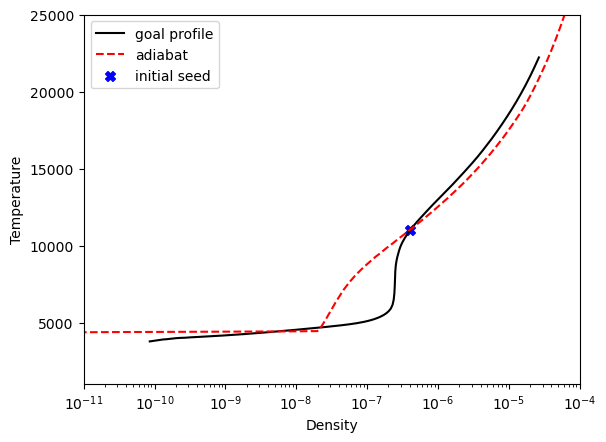

In [12]:
## Plotting
close()

# Curves
plt.plot(d_goal, T_goal, color="k",          label="goal profile")
plt.plot(d,      t,      color="r", ls="--", label="adiabat")

## initial point
plt.scatter([ρ_ini], [T_ini], color="b", marker="X", s=50, label="initial seed")

## Setup
plt.xlim(1e-11, 1e-4)
plt.ylim(1000, 25000)

#plt.axvline(3e-7)
#plt.axhline(10000)

## labels
plt.xlabel("Density")
plt.ylabel("Temperature")
plt.xscale("log")
plt.legend();

gcf()

Profiles against geometrical depth

In [13]:
## Plotting
close()

# Curves
plt.plot(ross_goal, T_goal, color="k",          label="goal profile")
plt.plot(ross,      t,      color="r", ls="--", label="adiabat")

## initial point
plt.scatter([z0*1e8], [T_ini], color="b", marker="X", s=50, label="initial seed")

## Setup
plt.xlim(-3e8, 1e8)
plt.ylim(1000, 25000)

## labels
plt.xlabel("Depth")
plt.ylabel("Temperature")
plt.legend();

gcf()

UndefVarError: UndefVarError: ross_goal not defined

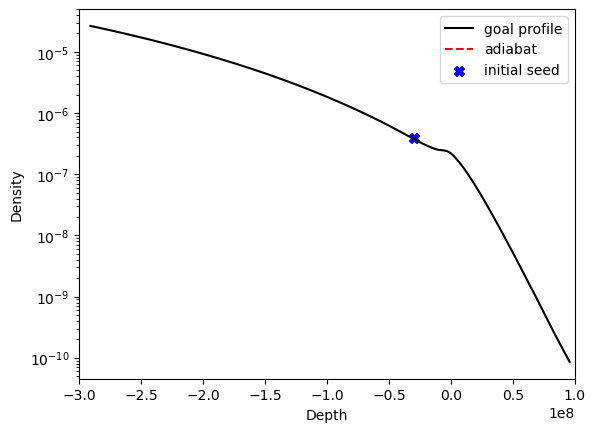

In [14]:
## Plotting
close()

# Curves
plt.plot(z_goal, d_goal, color="k",          label="goal profile")
plt.plot(ross,   d,      color="r", ls="--", label="adiabat")

## initial point
plt.scatter([z0*1e8], [ρ_ini], color="b", marker="X", s=50, label="initial seed")

## Setup
plt.xlim(-3e8, 1e8)
#plt.ylim(1000, 25000)

## labels
plt.xlabel("Depth")
plt.ylabel("Density")
plt.yscale("log")
plt.legend();

gcf()